<a href="https://colab.research.google.com/github/nachozobian/computer-vision-PyTorch/blob/main/computer_vision_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch computer vision notebook

This notebook is just me taking my first steps with computer vision in PyTorch.

* `torchvision` is part of the PyTorch project for computer vision! 
* `torchvision.datasets` get datasets and data loading functions
* `torchvision.models` get pretrained computer vision models
* `torchvision.transforms` manipulating your vision data to be suitable for ML
* `torch.utils.data.Dataset` Base dataset class for PyTorch
* `torch.utils.data.DataLoader` Python iterable object

In [1]:
#Import PyTorch
import torch
from torch import nn

#Import Torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

#Import matplotlib for visualization
import matplotlib.pyplot as plt

## Dataset

We'll be using the Fashion MNIST dataset: https://github.com/zalandoresearch/fashion-mnist

To Serious Machine Learning Researchers
Seriously, we are talking about replacing MNIST. Here are some good reasons:

**MNIST is too easy.** Convolutional nets can achieve 99.7% on MNIST. Classic machine learning algorithms can also achieve 97% easily. Check out our side-by-side benchmark for Fashion-MNIST vs. MNIST, and read "Most pairs of MNIST digits can be distinguished pretty well by just one pixel."


**MNIST is overused.** In this April 2017 Twitter thread, Google Brain research scientist and deep learning expert Ian Goodfellow calls for people to move away from MNIST.

**MNIST can not represent modern CV tasks**, as noted in this April 2017 Twitter thread, deep learning expert/Keras author François Chollet.

In [2]:
#Set up training data
train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = torchvision.transforms.ToTensor(),
    target_transform = None
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = torchvision.transforms.ToTensor(),
    target_transform = None
)

100%|██████████| 26421880/26421880 [00:03<00:00, 8738372.70it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 144733.31it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2689795.00it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 2087824.11it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
### Input and output shape?

image, label = train_data[0]
class_names = train_data.classes
print(f"Image shape: {image.shape} -> [color, height, width]")
print(f"Label is: {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color, height, width]
Label is: Ankle boot


(-0.5, 27.5, 27.5, -0.5)

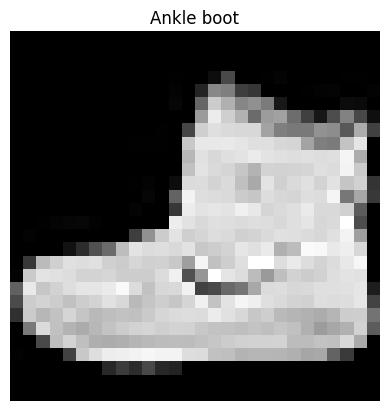

In [5]:
### Visualizing data
import matplotlib.pyplot as plt
image, label = train_data[0]
class_names = train_data.classes
plt.imshow(image.squeeze(), cmap="gray") #We add the squeeze just because PyTorch understands images as NCHW and matplotlib as NHWC
plt.title(class_names[label])
plt.axis(False)

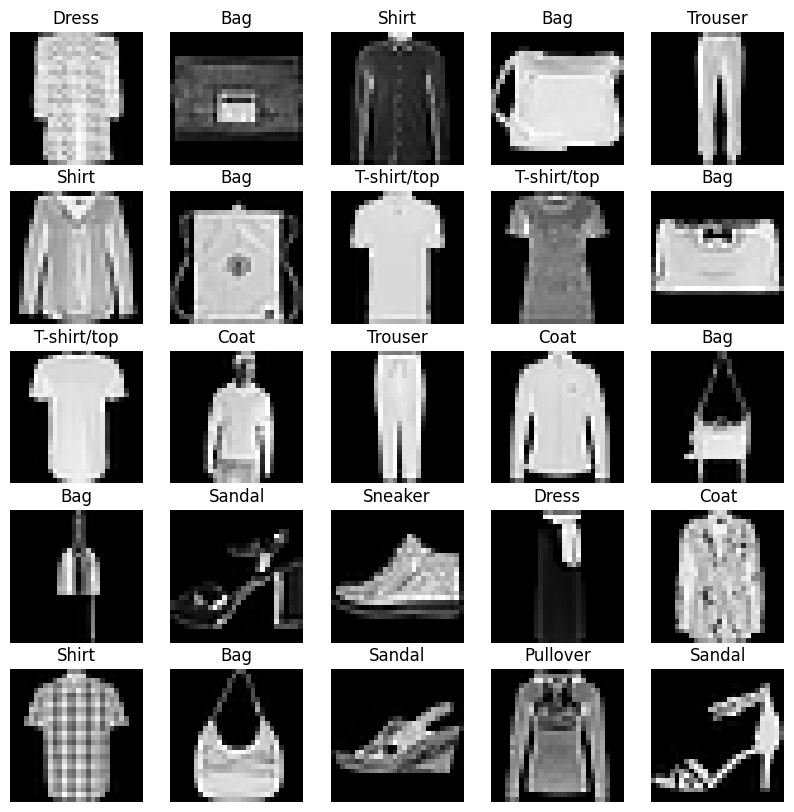

In [6]:
torch.manual_seed(14)
fig = plt.figure(figsize = (10, 10))
rows,cols = 5,5
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0,len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

Now we want to turn our dataset into a Python iterable and for that we'll use DataLoader.

**We need to turn our data into batches (mini-batches). In order to process it more efficiently**

Dividing our data into mini-batches gives the algorithm more opportunities to update our gradient when looking at our data

In [7]:
from torch.utils.data import DataLoader

## Divide our data into batches
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False)

##Creating a model

Baseline model: best practice!

A baseline model is a simple first approach model that will be improved iteratively.

In [8]:
from torch import nn

class FashionMNISTModel0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_shape: int, 
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(), # This flatten layer will encode our [1,28,28] space into [1,28*28] 
                      # so that we can  apply a Linear layer to the data.
        nn.Linear(in_features=input_shape,
                  out_features = hidden_shape),
        nn.Linear(in_features = hidden_shape,
                  out_features = output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [9]:
torch.manual_seed(14)


model0 = FashionMNISTModel0(
    input_shape=784,
    hidden_shape = 10, 
    output_shape = len(class_names)
).to("cpu")

model0

FashionMNISTModel0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

### Loss function, optimizer and metrics.

* Loss function: Since we're working with multi-class data, our loss function will be `nn.CrossEntropyLoss()`
* Optimizer: Stochastic Gradient Descent.
* Accuracy will be our evaluation metric. 

In [10]:
import requests
from pathlib import Path

#Download helper functions from repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exist, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
    

In [11]:
from helper_functions import accuracy_fn

#Set up loss function and optimizer 

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model0.parameters(),
                            lr = 0.1)

### Creating a function to time our experiments! 

Two of the main thing you'll want to track are:
1. Model's performance (loss and accuracy values etc)
2. How fast it runs! 

In [12]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time"""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

## Training our baseline model

We've splitted our data into batches so we've have to change something in our training procedure!

In [13]:
#Import tqdm
from tqdm.auto import tqdm 

#Seed and start the timer
torch.manual_seed(14)
train_time_start_on_cpu = timer()

epochs = 3

#Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch {epoch}\n--------")
  #Training
  train_loss = 0
  # Add a loop because our data is batchisized
  for batch, (X, y) in enumerate(train_dataloader):
    model0.train()
    y_pred = model0(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss #accumulate train loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples.")
  
  #Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)
  ##Testing
  test_loss, test_acc = 0, 0
  model0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      test_pred = model0(X_test)

      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
  print(f"\n Train loss: {train_loss:.4f} |Test loss: {test_loss:.4f}, Test acc: {test_acc: .4f}")

train_time_end_on_cpu = timer()
total_train_time = print_train_time(start = train_time_start_on_cpu,
                                    end = train_time_end_on_cpu,
                                    device = str(next(model0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
--------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

 Train loss: 0.5846 |Test loss: 0.6082, Test acc:  77.6657
Epoch 1
--------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

 Train loss: 0.4737 |Test loss: 0.4884, Test acc:  83.0471
Epoch 2
--------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

 Train loss: 0.4545 |Test loss: 0.4678, Test acc:  83.6761
Train time on cpu: 34.345 seconds


## Make prediction and get results !

In [14]:
torch.manual_seed(14)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  loss, acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader: 
      y_pred = model(X)
      
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y,
                         y_pred = y_pred.argmax(dim = 1))
      
    loss /= len(data_loader)
    acc /= len(data_loader)
      
  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(), 
          "model_acc": acc}

model0_results = eval_model(model0, data_loader= test_dataloader,
                            loss_fn = loss_fn, accuracy_fn = accuracy_fn)
model0_results

  

{'model_name': 'FashionMNISTModel0',
 'model_loss': 0.46784767508506775,
 'model_acc': 83.67611821086263}

###  Setup device agnostic code

In [15]:
!nvidia-smi

Wed May  3 10:56:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

## Improving our baseline model - Non Linearities! 

Create a model with a non linear and linear Layers!

In [17]:
#New model

class FashionMNISTModel1(nn.Module):
  def __init__(self, 
               input_shape:int,
               hidden_units:int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [28]:
torch.manual_seed(14)
model1 = FashionMNISTModel1(input_shape = 784,
                            hidden_units = 10,
                            output_shape=len(class_names)).to(device)

### Set up loss, optimizer and evaluation metrics.

In [29]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss() # measure how  wrong our model is
optimizer = torch.optim.SGD(params = model1.parameters(),
                            lr = 0.1) # tries to improve our model parameters based on the loss

### Functionizing training and evaluation training/testing loops 

In [30]:
#Function for train loop - train_step
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               accuracy_fn,
               device: torch.device = device):
  """Performs a training with model trying to learn on data_loader"""
  train_loss, train_acc = 0,0
  model.train()
  for batch, (X, y) in enumerate(data_loader):
    #Put data to device
    X, y  = X.to(device), y.to(device)

    #Forward pass
    y_pred = model(X)

    #Loss and accuracy per batch
    acc = accuracy_fn(y_true=y, y_pred = y_pred)
    loss = loss_fn(y_pred, y)
    train_loss += loss #accumulate train loss
    acc_loss += acc
    
    #Optimizer zero grad
    optimizer.zero_grad()

    #Loss backward
    loss.backward()

    #Step in the optimizer direction
    optimizer.step()


  #Divide total train loss  and accuracy by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f}, | Train acc: {train_acc:.2f}\n")

In [31]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Performs a testing loop step on model going over data_loader"""
  test_loss, test_acc = 0,0
  model.eval()
  #Turn on inference mode context manager
  with torch.inference_mode():
    for X,y in data_loader:
      #Data to target device
      X,y = X.to(device), y.to(device)
      #Forward pass
      test_pred = model(X)
      #Calculate the loss
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, 
                              y_pred = test_pred.argmax(dim=1)) #goes from logits -> prediction labels

    #Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Train loss: {test_loss:.5f}, | Train acc: {test_acc:.2f}\n")

In [32]:
torch.manual_seed(14)

#Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} \n--------------")
  train_step(model = model1,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer=optimizer,
             accuracy_fn = accuracy_fn,
             device = device)
  
  test_step(model=model1,
            data_loader= test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn= accuracy_fn,
            device=device)

train_time_end_on_gpu = timer()
total_train_time = print_train_time(start = train_time_start_on_gpu,
                                    end = train_time_end_on_gpu)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
--------------


RuntimeError: ignored

Wed May  3 11:16:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    28W /  70W |    601MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------